异常值检测主要是为了发现数据集中的一些"与众不同"的数据值，所谓“与众不同”的数据值是指这些数据与大多数数据存在较大的差异我们称之为“异常值”，并且在现实中这些“异常值”并没有被打上标签，因此我们必须通过某种算法来自动识别出这些异常值。对于异常值我们有如下的定义:

异常值所占整体数据的比例较少,产生异常值的概率非常低。
异常值本身的特征与其他正常值有明显的差异。

# 数据

在本篇博客中我们的数据来自于国外的某个超市的销售数据，你可以在这里下载: https://community.tableau.com/docs/DOC-1236

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel("./data/Superstore.xls")
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


# 查看Sales变量的分布

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64


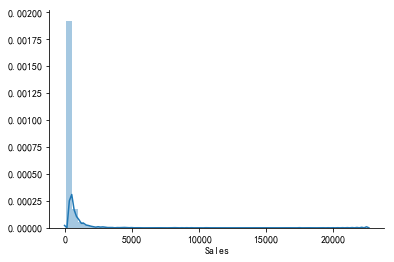

In [3]:
print(df.Sales.describe())
# df['Sales'].hist()
sns.distplot(df['Sales'])
sns.despine()

从分布上看,销售价格明显严重右偏,右侧有长尾,并且我们看到销售价格(sales)的异常区域大致应该分布在上图的红圈范围内。下面我们查看sales的偏度(Skewness)与峰度(Kurtosis)，偏度反应的是分布的偏斜程度,可能是左偏，右偏，长尾等形态，峰度反应分布的形状的胖瘦(宽窄),具体解释请参考这篇博客:
https://blog.csdn.net/binbigdata/article/details/79897160


In [4]:
print("Skewness: %f" % df['Sales'].skew())
print("Kurtosis: %f" % df['Sales'].kurt())

Skewness: 12.972752
Kurtosis: 305.311753


# 查看利润(Profit)分布

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64


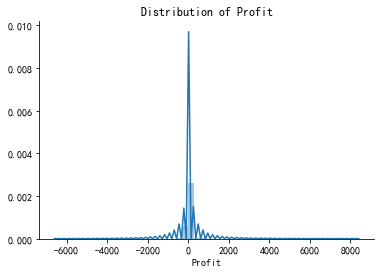

In [5]:
print(df.Profit.describe())
sns.distplot(df['Profit'])
plt.title("Distribution of Profit")
sns.despine()

从上图中我们可以发现 Profit分布似乎呈左右对称并且是单峰的形状,均值的左右两侧都有长尾且右侧长尾比左侧长尾更长(右侧最大值是800，左侧最小值是-6000)，因此总体上Profit分布呈现轻微右偏，数据出现在两侧长尾范围内的概率最低,因此异常区域应该处于左右两侧的红圈内。下面我们查看profit的偏度与峰度。

In [6]:
print("Skewness: %f" % df['Profit'].skew())
print("Kurtosis: %f" % df['Profit'].kurt())

Skewness: 7.561432
Kurtosis: 397.188515


# IsolationForest(隔离森林)

IsolationForest是一种简单有效的检测异常值的算法，它可以在数据的分布区域中找出异常值所在的区域，并对所有数据进行评分，那些落在异常区域的数据值会获得较低的分数，而那些不在异常区域中的数据将会获得较高的分数,大家可以参考这篇文章(https://dzone.com/articles/spotting-outliers-with-isolation-forest-using-skle )。在这篇文章中作者随机生成了两个正太分布N(-2,5)和N(2,5),同时通过隔离森林算法找到到了这两个分布中的异常区域,并且生成一条评分曲线,落在异常区域内的数据将会得到低分，落在异常区域内以外的数据将会获得高分:

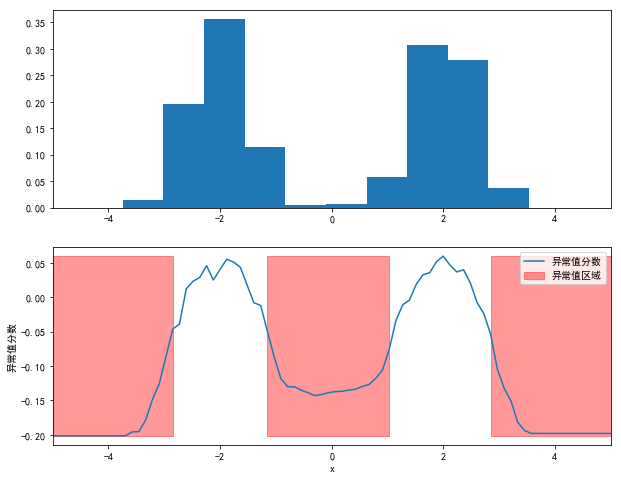

In [7]:
import numpy as np 
import matplotlib.pyplot as plt 
x = np.concatenate((np.random.normal(loc=-2, scale=.5,size=500), np.random.normal(loc=2, scale=.5, size=500)))

isolation_forest = IsolationForest(n_estimators=100) 
isolation_forest.fit(x.reshape(-1, 1)) 
xx = np.linspace(-6, 6, 100).reshape(-1,1) 
anomaly_score = isolation_forest.decision_function(xx) 
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.hist(x, normed=True) 
plt.xlim([-5, 5]) 

plt.subplot(2,1,2)
plt.plot(xx, anomaly_score, label='异常值分数') 
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where=outlier==-1, color='r', alpha=.4, label='异常值区域') 
plt.legend() 
plt.ylabel('异常值分数') 
plt.xlabel('x') 
plt.xlim([-5, 5]) 
plt.show()

# 使用隔离森林算法来探测Sales的异常值区域

隔离森林是一种检测异常值的算法，使用IsolationForest算法返回每个样本的异常分数，该算法基于这样的思想:异常是少数和在特征上不同的数据点。隔离森林是一种基于树的模型。在这些树中，通过首先随机选择特征然后在所选特征的最小值和最大值之间选择随机分割值来创建分区。下面我们使用隔离森林算法来探测sales的异常区域,并生成评分曲线:

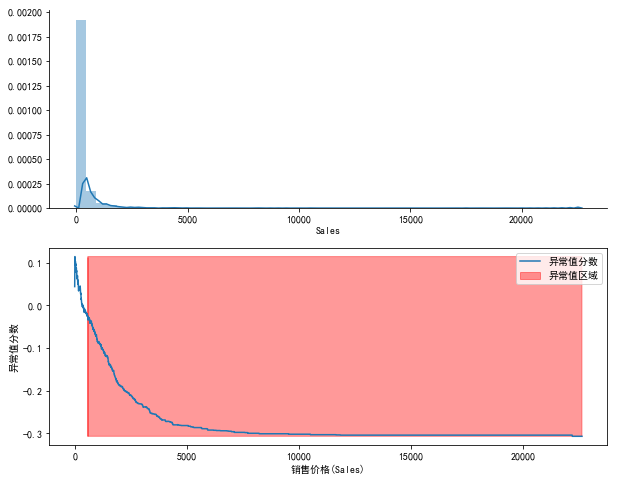

In [8]:
#定义隔离森林
isolation_forest = IsolationForest(n_estimators=100)
#训练销售价格数据
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))
#在销售价格的最小值和最大值之间分割数据
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1,1)
#生成所有数据的异常值分数
anomaly_score = isolation_forest.decision_function(xx)
#预测异常值
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
sns.distplot(df['Sales'])
sns.despine()

plt.subplot(2,1,2)
plt.plot(xx, anomaly_score, label='异常值分数')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='异常值区域')
plt.legend()
plt.ylabel('异常值分数')
plt.xlabel('销售价格(Sales)')
plt.show();

从上图中我们发现隔离森林算法很轻松的就识别出了Sales分布的异常区域(粉色矩形),并且生成了评分曲线,当数据落在粉色矩形的区域中时将会得到较低的评分,当数据落在粉色矩形区域以外时将会得到高分。下面是找出所有销售价格为异常值的销售记录。

In [9]:
print('销售价格最小异常值:',df[df.Sales>=xx[outlier==-1].min()].Sales.min())
df[df.Sales>=xx[outlier==-1].min()].head(10)

销售价格最小异常值: 566.97


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
7,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520,6,0.20,90.7152
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092
11,12,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.4240,4,0.20,68.3568
16,17,CA-2014-105893,2014-11-11,2014-11-18,Standard Class,PK-19075,Pete Kriz,Consumer,United States,Madison,...,53711,Central,OFF-ST-10004186,Office Supplies,Storage,"Stur-D-Stor Shelving, Vertical 5-Shelf: 72""H x...",665.8800,6,0.00,13.3176
24,25,CA-2015-106320,2015-09-25,2015-09-30,Standard Class,EB-13870,Emily Burns,Consumer,United States,Orem,...,84057,West,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,1044.6300,3,0.00,240.2649
27,28,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.4300,7,0.50,-1665.0522
35,36,CA-2016-117590,2016-12-08,2016-12-10,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,TEC-PH-10004977,Technology,Phones,GE 30524EE4,1097.5440,7,0.20,123.4737
54,55,CA-2016-105816,2016-12-11,2016-12-17,Standard Class,JM-15265,Janet Molinari,Corporate,United States,New York City,...,10024,East,TEC-PH-10002447,Technology,Phones,AT&T CL83451 4-Handset Telephone,1029.9500,5,0.00,298.6855


# 使用隔离森林算法来探测Profit的异常值区域

下面我们使用隔离森林算法来探测Profit的异常区域,并生成评分曲线

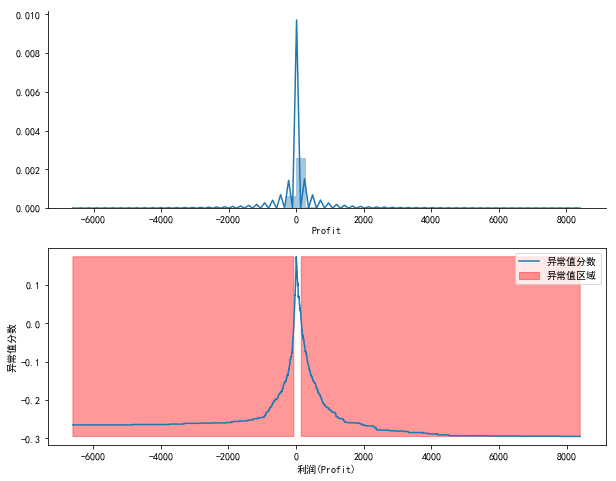

In [10]:
#定义隔离森林
isolation_forest = IsolationForest(n_estimators=100)
#训练销利润数据
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1,1)
#生成所有数据的异常值分数
anomaly_score = isolation_forest.decision_function(xx)
#预测异常值
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
sns.distplot(df['Profit'])
sns.despine()

plt.subplot(2,1,2)
plt.plot(xx, anomaly_score, label='异常值分数')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='异常值区域')
plt.legend()
plt.ylabel('异常值分数')
plt.xlabel('利润(Profit)')
plt.show();

在上图中隔离森林算法轻松的探测出来了Profit分布左右两侧的异常值区域，并生成了评分曲线。当数据落在左右两侧的分数矩形范围内时将会得到较低的分数,而当数据落在粉色矩形框的范围之外将会得到较高的分数。下面我们查看右两侧异常值的最小值,和左侧异常值的最大值。

In [11]:
x1=xx[outlier==-1]
right_min=x1[x1>0].min()
left_max = x1[x1<0].max()
print('右侧最小异常值为：',df[df.Profit>=right_min].Profit.min())
df[df.Profit>right_min].head(10)

右侧最小异常值为： 152.02319999999997


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
24,25,CA-2015-106320,2015-09-25,2015-09-30,Standard Class,EB-13870,Emily Burns,Consumer,United States,Orem,...,84057,West,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,1044.63,3,0.0,240.2649
54,55,CA-2016-105816,2016-12-11,2016-12-17,Standard Class,JM-15265,Janet Molinari,Corporate,United States,New York City,...,10024,East,TEC-PH-10002447,Technology,Phones,AT&T CL83451 4-Handset Telephone,1029.95,5,0.0,298.6855
117,118,CA-2015-110457,2015-03-02,2015-03-06,Standard Class,DK-13090,Dave Kipp,Consumer,United States,Seattle,...,98103,West,FUR-TA-10001768,Furniture,Tables,Hon Racetrack Conference Tables,787.53,3,0.0,165.3813
144,145,CA-2017-155376,2017-12-22,2017-12-27,Standard Class,SG-20080,Sandra Glassco,Consumer,United States,Independence,...,64055,Central,OFF-AP-10001058,Office Supplies,Appliances,Sanyo 2.5 Cubic Foot Mid-Size Office Refrigera...,839.43,3,0.0,218.2518
149,150,CA-2016-114489,2016-12-05,2016-12-09,Standard Class,JE-16165,Justin Ellison,Corporate,United States,Franklin,...,53132,Central,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",1951.84,8,0.0,585.5520
159,160,CA-2016-114104,2016-11-20,2016-11-24,Standard Class,NP-18670,Nora Paige,Consumer,United States,Edmond,...,73034,Central,TEC-PH-10004536,Technology,Phones,Avaya 5420 Digital phone,944.93,7,0.0,236.2325
244,245,CA-2014-131926,2014-06-01,2014-06-06,Second Class,DW-13480,Dianna Wilson,Home Office,United States,Lakeville,...,55044,Central,FUR-CH-10004063,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,2001.86,7,0.0,580.5394
247,248,CA-2014-131926,2014-06-01,2014-06-06,Second Class,DW-13480,Dianna Wilson,Home Office,United States,Lakeville,...,55044,Central,OFF-AP-10002945,Office Supplies,Appliances,Honeywell Enviracaire Portable HEPA Air Cleane...,1503.25,5,0.0,496.0725
251,252,CA-2016-145625,2016-09-11,2016-09-17,Standard Class,KC-16540,Kelly Collister,Consumer,United States,San Diego,...,92037,West,TEC-AC-10003832,Technology,Accessories,Logitech P710e Mobile Speakerphone,3347.37,13,0.0,636.0003


In [12]:
print('左侧侧最大异常值为：',df[df.Profit<=left_max].Profit.max())
df[df.Profit<=left_max].head(10)

左侧侧最大异常值为： -67.5435


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
14,15,US-2015-118983,2015-11-22,2015-11-26,Standard Class,HP-14815,Harold Pawlan,Home Office,United States,Fort Worth,...,76106,Central,OFF-AP-10002311,Office Supplies,Appliances,Holmes Replacement Filter for HEPA Air Cleaner...,68.8100,5,0.80,-123.8580
27,28,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.4300,7,0.50,-1665.0522
36,37,CA-2016-117590,2016-12-08,2016-12-10,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, ...",190.9200,5,0.60,-147.9630
72,73,US-2015-134026,2015-04-26,2015-05-02,Standard Class,JE-15745,Joel Eaton,Consumer,United States,Memphis,...,38109,South,FUR-CH-10000513,Furniture,Chairs,High-Back Leather Manager's Chair,831.9360,8,0.20,-114.3912
118,119,US-2015-136476,2015-04-05,2015-04-10,Standard Class,GG-14650,Greg Guthrie,Corporate,United States,Bristol,...,37620,South,OFF-BI-10003650,Office Supplies,Binders,GBC DocuBind 300 Electric Binding Machine,157.7940,1,0.70,-115.7156
125,126,US-2014-134614,2014-09-20,2014-09-25,Standard Class,PF-19165,Philip Fox,Consumer,United States,Bloomington,...,61701,Central,FUR-TA-10004534,Furniture,Tables,Bevis 44 x 96 Conference Tables,617.7000,6,0.50,-407.6820
165,166,CA-2014-139892,2014-09-08,2014-09-12,Standard Class,BM-11140,Becky Martin,Consumer,United States,San Antonio,...,78207,Central,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,8159.9520,8,0.40,-1359.9920
169,170,CA-2014-139892,2014-09-08,2014-09-12,Standard Class,BM-11140,Becky Martin,Consumer,United States,San Antonio,...,78207,Central,OFF-AP-10002518,Office Supplies,Appliances,Kensington 7 Outlet MasterPiece Power Center,177.9800,5,0.80,-453.8490
174,175,US-2014-100853,2014-09-14,2014-09-19,Standard Class,JB-15400,Jennifer Braxton,Corporate,United States,Chicago,...,60623,Central,OFF-AP-10000891,Office Supplies,Appliances,Kensington 7 Outlet MasterPiece HOMEOFFICE Pow...,52.4480,2,0.80,-131.1200


上述两个可视化结果显示了异常值分数并突出显示异常值所在的区域。从图中可见异常分数反映了基础分布的形状，异常区域对应于低概率区域。然而，到目前为止我们只是对Sales和Profit这两个单一变量分别进行了分析。如果我们仔细研究,可能会发现，由我们的模型确定的一些异常值只不过是数学统计上的异常,它可能并非是我们业务场景中的异常值,比如某些利润很高的订单可能是由于商品本身的利润高所导致,它可能在统计分布上是异常值,但它在实际的业务场景中并不应该是异常值。下面我们同时观察Sales和Profit这两个变量的散点分布,并对Sales和Profit进行线性拟合,那些严重偏离拟合曲线的点,可以被认为是异常值,以这样的方式来判定异常值更符合实际的业务场景。

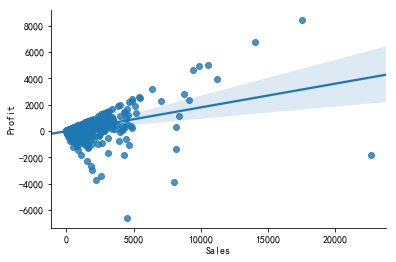

In [13]:
sns.regplot(x="Sales", y="Profit", data=df)
sns.despine();

当我们的数据不是不是单变量时而是多元变量时，异常检测的方法变得更加计算密集并且在数学上更复杂。

# CBLOF(Cluster-based Local Outlier Factor)

CBLOF算法时基于聚类组的本地异常因子计算异常值分数。  
CBLOF将数据集和由聚类算法生成的聚类模型作为输入。它使用参数alpha和beta将群集分为小群集和大群集。然后基于该点所属的聚类的大小以及到最近的大聚类的距离来计算异常分数。我们使用PyOD(https://pyod.readthedocs.io/en/latest/index.html) 库来实现CBLOF算法(https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.cblof)

* 将销售额和利润标准化处理将其缩放到0到1之间。
* 根据经验将设置异常值比例设置为1％。
* 使用CBLOF模型拟合数据并预测结果。
* 使用阈值来考虑数据点是正常值还是异常值。
* 使用决策函数计算每个点的异常值分数。

In [14]:
cols = ['Sales', 'Profit']
minmax = MinMaxScaler(feature_range=(0, 1))
print(df[cols].head())
print('---------------------')
df[['Sales','Profit']] = minmax.fit_transform(df[['Sales','Profit']])
print(df[['Sales','Profit']].head())


      Sales    Profit
0  261.9600   41.9136
1  731.9400  219.5820
2   14.6200    6.8714
3  957.5775 -383.0310
4   22.3680    2.5164
---------------------
      Sales    Profit
0  0.011552  0.442794
1  0.032313  0.454639
2  0.000626  0.440458
3  0.042280  0.414464
4  0.000968  0.440168


下面的代码参考了"比较所有已实现的离群值检测模型的例子"(https://github.com/yzhao062/pyod/blob/master/notebooks/Compare%20All%20Models.ipynb) 和"使用PyOD库在Python中学习异常检测的一个很棒的教程"(https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/) 这两篇文章。

异常值数量: 100 正常值数量: 9894


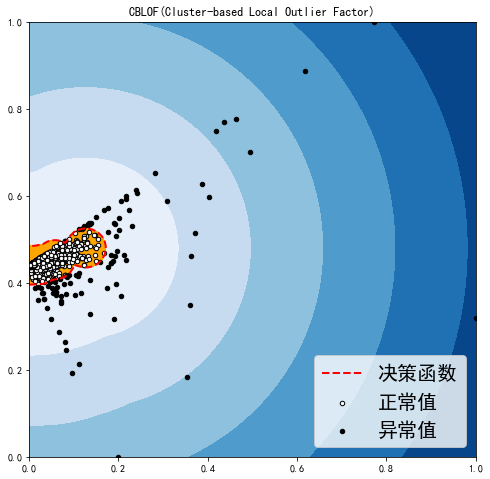

In [15]:
#将Sales和Profit合并成一个两列的numpy数组
X1 = df['Sales'].values.reshape(-1,1)
X2 = df['Profit'].values.reshape(-1,1)
X = np.concatenate((X1,X2),axis=1)

#设定异常值比例
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

#定义CBLOF模型
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)

#训练数据
clf.fit(X)
# 预测异常值分数
scores_pred = clf.decision_function(X) * -1
        
# 预测异常值和正常值的数据
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
#过滤出Sales和Profit的正常值
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
#过滤出Sales和Profit的异常值
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('异常值数量:',n_outliers,'正常值数量:',n_inliers)
        
# 设定一个阈值用以识别正常值和异常值的标准
threshold = np.percentile(scores_pred, 100 * outliers_fraction)
        
#决策函数为每一个数据点计算异常值分数
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
#在图上对从最小的异常值分数到阈值的范围内进行分层着色
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
#在异常值分数等于阈值处画红色线条
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
#填充橙色轮廓线，其中异常分数的范围是从阈值到最大异常分数
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['决策函数', '正常值','异常值'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('CBLOF(Cluster-based Local Outlier Factor)')
plt.show();

# 基于直方图的离群值检测（HBOS）

HBOS(https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.hbos) 假设特征独立，并通过构建直方图来计算异常程度。 在多变量异常检测中，可以计算每个单个特征的直方图，单独评分并在最后组合。 使用PyOD库时，代码与CBLOF非常相似。

异常值数量: 90 正常值: 9904


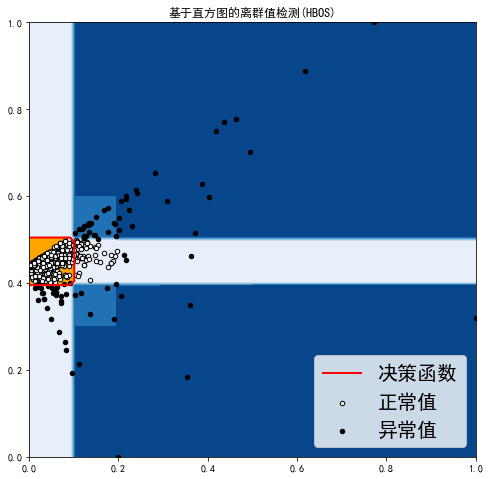

In [16]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination=outliers_fraction)
clf.fit(X)

scores_pred = clf.decision_function(X) * -1
        

y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('异常值数量:',n_outliers,'正常值:',n_inliers)

threshold = np.percentile(scores_pred, 100 * outliers_fraction)
        
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)

a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
     
plt.legend([a.collections[0], b,c], ['决策函数', '正常值','异常值'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('基于直方图的离群值检测(HBOS)')
plt.show();

# 隔离森林

隔离森林其原理与随机森林类似，建立在决策树的基础上。 隔离林通过随机选择特征然后根据特征的最大值和最小值之间的分割值来隔离观察。
PyOD Isolation Forest模块(https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest) 是Scikit-learn Isolation Forest的wrapper，它具有更多功能。其代码与之前的CBLOF非常相似。

异常值数量:  99 正常值数量:  9895


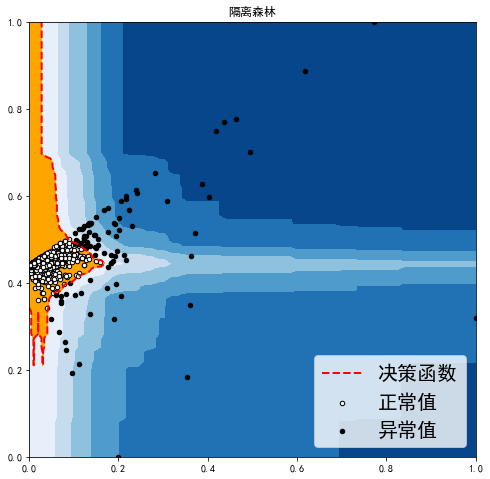

In [17]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)

scores_pred = clf.decision_function(X) * -1
        
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()

inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)

outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('异常值数量: ',n_outliers,'正常值数量: ',n_inliers)
        
threshold = np.percentile(scores_pred, 100 * outliers_fraction)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['决策函数', '正常值','异常值'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('隔离森林')
plt.show();

# KNN(K - Nearest Neighbors)

用于离群检测的pyod.models.knn.KNN(https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn)。 对于数据，它与第k个最近邻居的距离可以被视为异常值。其代码与之前的CBLOF非常相似。

异常值数量:  91 正常值数量:  9903


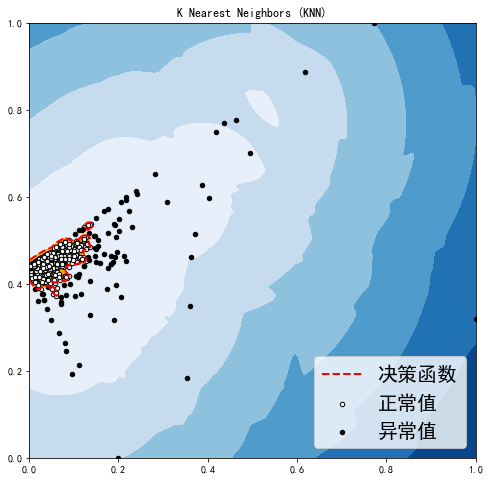

In [18]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination=outliers_fraction)
clf.fit(X)

scores_pred = clf.decision_function(X) * -1
        
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('异常值数量: ',n_outliers,'正常值数量: ',n_inliers)
        
threshold = np.percentile(scores_pred, 100 * outliers_fraction)
        
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([a.collections[0], b,c], ['决策函数', '正常值','异常值'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K Nearest Neighbors (KNN)')
plt.show();

上述四种算法预测的异常并无太大差异。

# 对异常订单的研究 

我们要研究一下由我们的模型确定的每个异常值，例如，让我们详细查看由KNN确定的几个异常值订单，并尝试理解是什么导致它们异常。

In [19]:
df = pd.read_excel("./data/Superstore.xls")

In [20]:
df.iloc[1995]

Row ID                                                        1996
Order ID                                            US-2017-147221
Order Date                                     2017-12-02 00:00:00
Ship Date                                      2017-12-04 00:00:00
Ship Mode                                             Second Class
Customer ID                                               JS-16030
Customer Name                                            Joy Smith
Segment                                                   Consumer
Country                                              United States
City                                                       Houston
State                                                        Texas
Postal Code                                                  77036
Region                                                     Central
Product ID                                         OFF-AP-10002534
Category                                           Office Supp

对于上面这个订单，客户购买了5种产品，总价格为294.62，利润低于-766，折扣80％。 打八折居然还损失这么多,的确不可思议，看来模型认定它是异常值是合理的。我们再看一个订单:

In [21]:
df.iloc[9649]

Row ID                                            9650
Order ID                                CA-2016-107104
Order Date                         2016-11-26 00:00:00
Ship Date                          2016-11-30 00:00:00
Ship Mode                               Standard Class
Customer ID                                   MS-17365
Customer Name                      Maribeth Schnelling
Segment                                       Consumer
Country                                  United States
City                                       Los Angeles
State                                       California
Postal Code                                      90045
Region                                            West
Product ID                             FUR-BO-10002213
Category                                     Furniture
Sub-Category                                 Bookcases
Product Name     DMI Eclipse Executive Suite Bookcases
Sales                                          3406.66
Quantity  

对于上面这个订单,客户购买了8件商品,总金额为3406.66，折扣15％，打了一五折利润只有160.314，利润率只有4.7%，一般认为商家的利润率不应该这么低,卖100块钱的货只赚4.7元，这有点不可思议，所以我们的模型也发现了这点，将其认定为异常订单看来是合理的。

In [22]:
df.iloc[9270]

Row ID                                                 9271
Order ID                                     US-2017-102183
Order Date                              2017-08-21 00:00:00
Ship Date                               2017-08-28 00:00:00
Ship Mode                                    Standard Class
Customer ID                                        PK-19075
Customer Name                                     Pete Kriz
Segment                                            Consumer
Country                                       United States
City                                          New York City
State                                              New York
Postal Code                                           10035
Region                                                 East
Product ID                                  OFF-BI-10001359
Category                                    Office Supplies
Sub-Category                                        Binders
Product Name     GBC DocuBind TL300 Elec

对于上面这个订单，客户以总价4305购买了6件产品，经过20％的折扣后，我们仍然获得了超过33％的利润。这也非常的不可思议，模型将其认定为异常订单看来也是合理的。 